In [2]:
import numpy as np
import pandas as pd
import artist_info_helper as aih

import glob, os, re, sys
from datetime import datetime
import pickle
import time
import copy
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('mpl_style_Jeffreson.mplstyle')
def percent_formatter(x, pos):
    return f'{x*100:.1f}\%'
def log_format(x, pos):
    return f'{int(x)}'

from wordcloud import WordCloud

# clean random artists collected

In [13]:
df_numartists = pd.read_csv(DEFAULT_RND_DIR + "/Editorial-playlists/num_featured_artists.csv")
numartists = [int(elem) for elem in df_numartists['num_artists'] if elem!='missed']
numartists = [elem if elem <= 1000 else 1000 for elem in numartists]
print(numartists)
print(sum(numartists))

[1000, 185, 1000, 885, 1000, 1000, 1000, 488, 470, 1000, 945, 1000, 1000, 129, 120, 599, 1000, 1000, 928, 1000, 637, 919, 911, 749, 1000, 908, 432, 960, 663, 1000, 1000, 1000, 1000, 1000, 597, 311, 854, 1000, 1000, 1000]
32690


In [4]:
DEFAULT_RND_DIR = "/n/holystore01/LABS/itc_lab/Users/sjeffreson/serch/artist-database/"
df = pd.read_csv(DEFAULT_RND_DIR + "Spotify_artist_info_Mnth-Lstnrs.csv")
print(df.columns)
df.describe()

Index(['ids', 'names', 'popularity', 'followers', 'genres', 'first_release',
       'last_release', 'num_releases', 'num_tracks', 'monthly_listeners'],
      dtype='object')


,popularity,followers,first_release,last_release,num_releases,num_tracks,monthly_listeners
count,35629.000000,3.562900e+04,35629.000000,35629.000000,35629.000000,35629.000000,3.561900e+04
mean,9.552078,3.980929e+04,1678.939431,1685.920093,6.121642,5.055348,1.099071e+05
std,14.123788,7.226201e+05,745.068107,748.116910,6.684658,11.789091,1.262286e+06
min,0.000000,0.000000e+00,-1.000000,-1.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,2.900000e+01,1994.000000,2008.000000,1.000000,1.000000,2.000000e+01
50%,2.000000,2.020000e+02,2010.000000,2019.000000,3.000000,2.000000,2.610000e+02
75%,15.000000,1.718000e+03,2017.000000,2023.000000,9.000000,6.000000,4.984000e+03
max,92.000000,8.726594e+07,2024.000000,2024.000000,20.000000,810.000000,8.135858e+07


In [3]:
# we don't need the popularity or followers counts (we have Monthly Listeners), but everything
# else should be present, and indicates a problem if it's not (artists should have releases and
# tracks, and information about these). Therefore drop any rows with -1 values or NaNs in these
# columns (we assigned -1 to missing values in the data collection process).
features = ['first_release', 'last_release', 'num_releases', 'num_tracks', 'monthly_listeners']
df = df.dropna(subset=[column for column in df.columns if column in features])
df = df.drop(df[(df[features] == -1).any(axis=1)].index)
df.describe()

,popularity,followers,first_release,last_release,num_releases,num_tracks,monthly_listeners
count,26410.000000,2.641000e+04,26410.000000,26410.000000,26410.000000,26410.000000,2.641000e+04
mean,11.073381,4.324070e+04,2009.278190,2017.657440,7.335517,6.039947,1.214154e+05
std,14.847439,5.864336e+05,12.569096,8.614065,6.670121,12.658448,1.175614e+06
min,0.000000,0.000000e+00,1877.000000,1900.000000,1.000000,1.000000,0.000000e+00
25%,0.000000,6.100000e+01,2005.000000,2015.000000,2.000000,1.000000,4.200000e+01
50%,4.000000,3.470000e+02,2013.000000,2021.000000,5.000000,3.000000,5.040000e+02
75%,18.000000,2.634000e+03,2018.000000,2023.000000,11.000000,8.000000,8.421500e+03
max,88.000000,4.948724e+07,2024.000000,2024.000000,20.000000,810.000000,6.784168e+07


In [4]:
# print the genres
print(df['genres'].head(10))

0                                     NaN
1                                     NaN
2                                     opm
3                                     NaN
4                                     NaN
5                                     NaN
6             dark post-punk, modern goth
7                           gym hardstyle
9                                     NaN
10    abstract hip hop, minnesota hip hop
Name: genres, dtype: object


In [5]:
# Non-exhaustive, most common genres from the word cloud, in alphabetical order:
gnrslct = [
  'ambient', 'blues', 'christian', 'classical', 'dance', 'electro',
  'folk', 'funk', 'hip hop', 'house', 'indie', 'jazz', 'metal', 'pop',
  'punk', 'rap', 'reggae', 'rock', 'singer-songwriter', 'soul', 'techno'
]

# generate separate dataframes for sets of artists with each genre word somewhere in
# their names
gnrdfs = {}
indices_assigned = []
gnrdfs['NA'] = df[df['genres'].isna()]
df_gnrs = df.dropna(subset=['genres'])
for g in gnrslct:
    gnrdfs[g] = df_gnrs[df_gnrs['genres'].str.contains(g, case=False)]
    indices_assigned.extend(list(gnrdfs[g].index))
indices_assigned = list(set(indices_assigned))
gnrdfs['other'] = df_gnrs.drop(indices_assigned)

In [6]:
# order and color by number of entries
gnrnames = [key for key in gnrdfs.keys()]
gnrcounts = [len(gnrdfs[key]) for key in gnrnames]
gnrvals = [gnrdfs[key] for key in gnrnames]

gnrnames = [name for _, name in sorted(zip(gnrcounts, gnrnames))]
gnrvals = [val for _, val in sorted(zip(gnrcounts, gnrvals))]
gnrcounts = sorted(gnrcounts)
vmin = np.log(min(gnrcounts))
vmax = np.log(max(gnrcounts))
colors = [plt.cm.plasma_r(
    (np.log(count)-vmin)/(vmax-vmin)
) for count in gnrcounts]

3.998372215398726 0.6762301378794104


/tmp/ipykernel_1097380/2753488408.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(


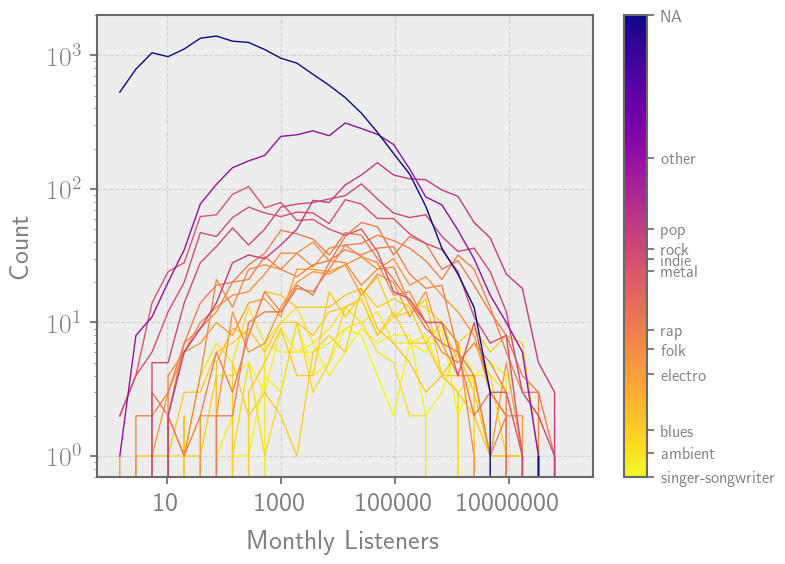

In [13]:
# plot the histograms of Monthly Listeners separately for each genre, on the same axis
fig, ax = plt.subplots(figsize=(8, 6))
medians = []
for name, val, color in zip(gnrnames, gnrvals, colors):
    hist, bins_edges = np.histogram(val['monthly_listeners'], bins=np.logspace(0., 8.2, 30), range=(0., 6.5))
    medians.append(np.median(val['monthly_listeners']))
    bin_centers = (bins_edges[:-1] + bins_edges[1:]) / 2
    ax.plot(bin_centers, hist, label=name, lw=1, color=color)

# print the mean of the medians and the std to see if the NA one is an outlier
print(np.mean(np.log10(medians)), np.std(np.log10(medians)))

# reduce labels for the colorbar
gnrnames_plt = gnrnames[:-6:3] + gnrnames[-6:]
gnrcounts_plt = gnrcounts[:-6:3] + gnrcounts[-6:]
cbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap=plt.cm.plasma_r),
    ticks=np.linspace(vmin, vmax, 5),
    norm=plt.Normalize(vmin=vmin, vmax=vmax)
)
cbar.set_ticks((np.log(gnrcounts_plt)-vmin)/(vmax-vmin))
cbar.set_ticklabels([f'{name}' for name in gnrnames_plt], fontsize=12)

plt.xscale('log')
plt.yscale('log')
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(log_format))
plt.xlabel('Monthly Listeners')
plt.ylabel('Count')

plt.savefig("/n/holystore01/LABS/itc_lab/Users/sjeffreson/serch/figs/monthly_listeners_by_genre.png",
            format='png', bbox_inches='tight', dpi=200)
plt.show()

In [71]:
# now remove artists with no genre
features = ['genres']
df_negtracks = df.dropna(subset=[column for column in df.columns if column in features])
df_negtracks = df_negtracks.drop(df_negtracks[(df_negtracks[features] == -1).any(axis=1)].index)
df_negtracks.describe()

,popularity,followers,first_release,last_release,num_releases,num_tracks,monthly_listeners
count,10219.000000,1.021900e+04,10219.000000,10219.000000,10219.000000,10219.000000,1.021900e+04
mean,20.001272,1.093213e+05,2006.411488,2018.849790,10.385361,5.627459,2.921387e+05
std,17.323969,9.386214e+05,13.505154,7.652542,7.138718,11.241363,1.842493e+06
min,0.000000,2.000000e+00,1899.000000,1930.000000,1.000000,1.000000,0.000000e+00
25%,5.000000,6.890000e+02,2001.000000,2017.000000,4.000000,1.000000,7.290000e+02
50%,17.000000,3.220000e+03,2010.000000,2022.000000,9.000000,3.000000,7.304000e+03
75%,31.000000,1.754450e+04,2016.000000,2023.000000,20.000000,7.000000,5.558400e+04
max,88.000000,4.948724e+07,2024.000000,2024.000000,20.000000,810.000000,6.784168e+07


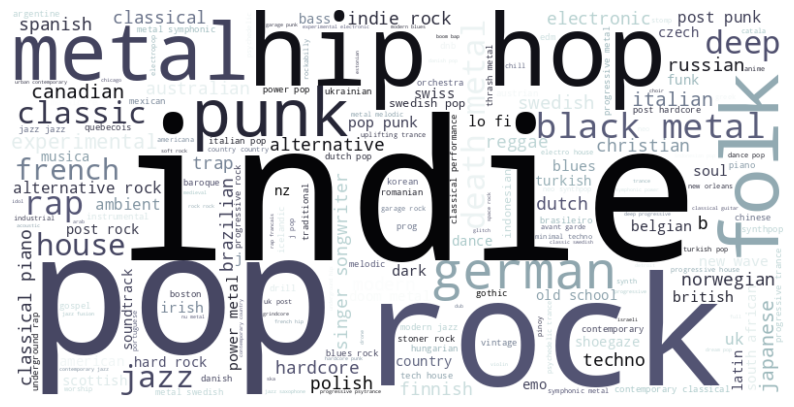

In [46]:
# another important thing to check is the pool of genres we have here, as this is a categorical
# variable, and it's possible that some genres need to be treated separately, due to very different
# listenership demographics that don't overlap with the other genres (e.g. classical music, traditional
# music, lo-fi, i.e. anything that is often used as background music).

# flatten all genres into a single string
genre_string = " ".join(df['genres'].str.cat(sep=" ").split(", "))
genre_string = re.sub(r'\s+', ' ', genre_string)

# word-cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=plt.cm.bone).generate(genre_string)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig("/n/holystore01/LABS/itc_lab/Users/sjeffreson/serch/figs/wordcloud.png",
            format='png', bbox_inches='tight', dpi=200)
plt.show()

In [47]:
pattern = '|'.join(gnrslct)
df_gnrslct = df[df['genres'].str.contains(pattern)]
df_gnrslct.describe()

,popularity,followers,first_release,last_release,num_releases,num_tracks,monthly_listeners
count,7463.000000,7.463000e+03,7463.000000,7463.000000,7463.000000,7463.000000,7.463000e+03
mean,20.622270,1.299878e+05,2006.543079,2019.126357,10.611550,5.188932,3.457746e+05
std,17.846167,1.038612e+06,13.329896,7.369701,7.122722,6.606970,2.083846e+06
min,0.000000,2.000000e+00,1899.000000,1930.000000,1.000000,1.000000,0.000000e+00
25%,5.000000,7.740000e+02,2002.000000,2018.000000,4.000000,1.000000,7.085000e+02
50%,17.000000,3.906000e+03,2010.000000,2022.000000,9.000000,3.000000,8.121000e+03
75%,32.000000,2.279650e+04,2016.000000,2023.000000,20.000000,7.000000,6.430650e+04
max,88.000000,4.948724e+07,2024.000000,2024.000000,20.000000,109.000000,6.784168e+07


In [48]:
print(df.loc[df['first_release'].idxmin()])

ids                                6nLkWu5DSXItXcB6q2ISTO
names                              gerry mulligan quartet
popularity                                             40
followers                                           21294
genres               bebop, cool jazz, jazz, jazz quartet
first_release                                        1899
last_release                                         2022
num_releases                                           18
num_tracks                                              7
monthly_listeners                                203960.0
Name: 5352, dtype: object


# same cleaning for the featured artists

In [50]:
#del df_edits

In [51]:
DEFAULT_EDITORIAL_DIR = "/n/holystore01/LABS/itc_lab/Users/sjeffreson/serch/artist-database/Editorial-playlists/"
names = glob.glob(DEFAULT_EDITORIAL_DIR + "artists_last_24hrs_*_info.csv")
for name in names:
    df_edit = pd.read_csv(name)
    if 'df_edits' in locals():
        df_edits = pd.concat([df_edits, df_edit])
    else:
        df_edits = df_edit
print(len(df_edits))

24020


In [52]:
# uh oh! Most of this removal is due to genres. We need to find a way to attach genres to artists
# that have no genre.
features = ['genres']
df_edits_negtracks = df_edits.dropna(subset=[column for column in df_edits.columns if column in features])
df_edits_negtracks = df_edits_negtracks.drop(df_edits_negtracks[(df_edits_negtracks[features] == -1).any(axis=1)].index)
print(len(df_edits_negtracks))

16140


In [53]:
features = ['first_release', 'last_release', 'num_releases', 'num_tracks', 'monthly_listeners', 'genres']
df_edits = df_edits.dropna(subset=[column for column in df_edits.columns if column in features])
df_edits = df_edits.drop(df_edits[(df_edits[features] == -1).any(axis=1)].index)
df_edits.describe()

,monthly_listeners,popularity,followers,first_release,last_release,num_releases,num_tracks
count,1.602800e+04,16028.000000,1.602800e+04,16028.000000,16028.000000,16028.000000,16028.000000
mean,7.576075e+06,55.213564,3.103694e+06,2012.179873,2023.274395,17.159720,2.722361
std,1.426283e+07,17.282934,9.634563e+06,43.293423,2.107743,4.850823,4.232190
min,0.000000e+00,0.000000,9.000000e+00,0.000000,1972.000000,1.000000,1.000000
25%,2.588382e+05,42.000000,2.650975e+04,2010.000000,2023.000000,15.000000,1.000000
50%,1.342874e+06,55.000000,2.118945e+05,2017.000000,2024.000000,20.000000,1.000000
75%,7.816571e+06,69.000000,1.602604e+06,2020.000000,2024.000000,20.000000,2.000000
max,1.135538e+08,100.000000,1.137957e+08,2024.000000,2024.000000,20.000000,100.000000


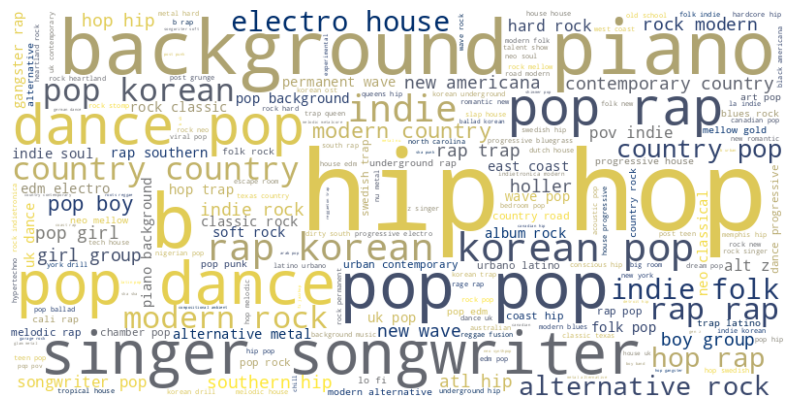

In [54]:
# flatten all genres into a single string
genre_string = " ".join(df_edits['genres'].str.cat(sep=" ").split(", "))
genre_string = re.sub(r'\s+', ' ', genre_string)

# word-cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=plt.cm.cividis).generate(genre_string)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig("/n/holystore01/LABS/itc_lab/Users/sjeffreson/serch/figs/wordcloud-featured.png",
            format='png', bbox_inches='tight', dpi=200)
plt.show()

In [55]:
pattern = '|'.join(gnrslct)
df_edits_gnrslct = df_edits[df_edits['genres'].str.contains(pattern)]
df_edits_gnrslct.describe()

,monthly_listeners,popularity,followers,first_release,last_release,num_releases,num_tracks
count,1.320100e+04,13201.000000,1.320100e+04,13201.00000,13201.000000,13201.000000,13201.000000
mean,8.808245e+06,57.438830,3.692119e+06,2012.03371,2023.225589,17.824104,2.907507
std,1.525913e+07,17.151303,1.048527e+07,10.54180,2.182753,4.298604,4.484638
min,0.000000e+00,0.000000,9.000000e+00,1954.00000,1972.000000,1.000000,1.000000
25%,3.510010e+05,45.000000,5.706900e+04,2009.00000,2023.000000,18.000000,1.000000
50%,2.124204e+06,59.000000,3.632270e+05,2016.00000,2024.000000,20.000000,1.000000
75%,9.915587e+06,71.000000,2.334394e+06,2019.00000,2024.000000,20.000000,3.000000
max,1.135538e+08,100.000000,1.137957e+08,2024.00000,2024.000000,20.000000,100.000000


# plot the Monthly Listener distributions

In [56]:
ds = pd.Series(df_gnrslct['monthly_listeners'])
ds_edits = pd.Series(df_edits_gnrslct['monthly_listeners'])

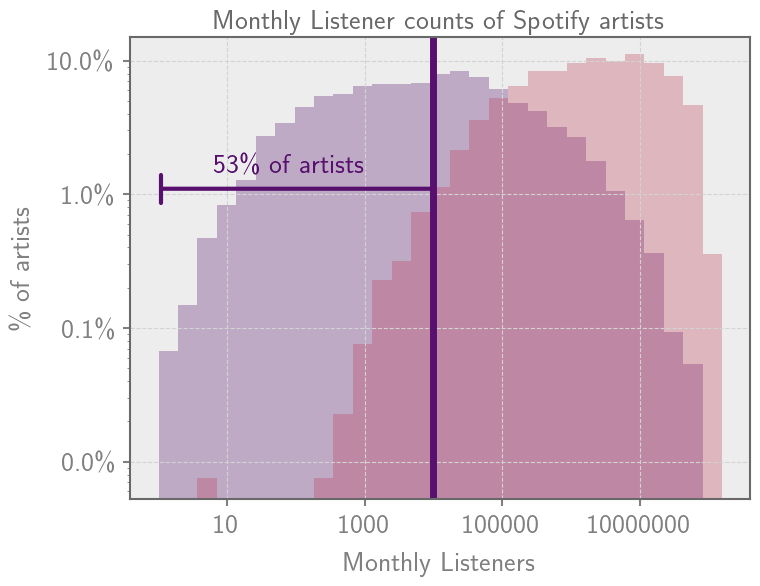

In [59]:
plt.figure(figsize=(8, 6))

# plot data
weights = np.ones_like(ds) / len(ds)
plt.hist(ds, bins=np.logspace(0., 8.2, 30), weights=weights,
         alpha=0.3, lw=2, log=True, color=plt.cm.inferno(0.25))
weights_edits = np.ones_like(ds_edits) / len(ds_edits)
plt.hist(ds_edits, bins=np.logspace(0., 8.2, 30), weights=weights_edits,
         alpha=0.3, lw=2, log=True, color=plt.cm.inferno(0.5))

# percentile rank below 10000
plt.axvline(10000., color=plt.cm.inferno(0.25), lw=5)
percentage_below = ((ds < 10000.).mean() * 100).round().astype(int)
plt.annotate(f'{percentage_below}\% of artists', xy=(1000., 0.02), xytext=(1000., 0.02),
             va='top', ha='right', color=plt.cm.inferno(0.25))
plt.annotate('',
    xy=(1., 0.011), xytext=(10000., 0.011),
    arrowprops=dict(arrowstyle="|-|,widthA=0.,widthB=0.5", facecolor=plt.cm.inferno(0.25), edgecolor=plt.cm.inferno(0.25), lw=3),
)

plt.xscale('log')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(percent_formatter))
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(log_format))

plt.title(r'Monthly Listener counts of Spotify artists', color='dimgrey')
plt.xlabel(r'Monthly Listeners')
plt.ylabel(r'\% of artists')
plt.ylim([plt.gca().get_ylim()[0], 0.15])

# plt.savefig("/n/holystore01/LABS/itc_lab/Users/sjeffreson/serch/figs/total_dstbn.png",
#             format='png', bbox_inches='tight', dpi=200)
plt.show()

# separate out active artists

In [60]:
active_artists = aih.get_active_artists(df_gnrslct)
ds_active = pd.Series(active_artists['monthly_listeners'])
ds_active = ds_active[ds_active>0]
print(len(ds_active))

159


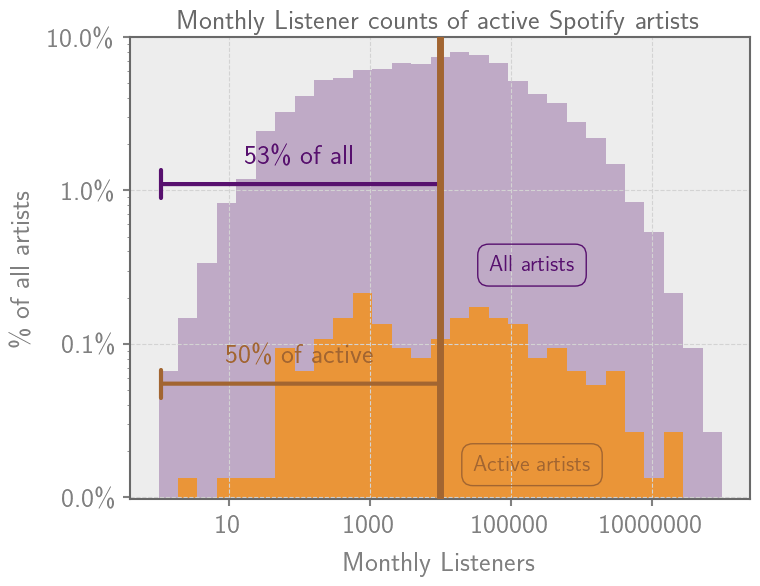

In [61]:
plt.figure(figsize=(8, 6))

# plot data
weights = np.ones_like(ds) / len(ds)
plt.hist(ds, bins=np.logspace(0., 8., 30), weights=weights,
         alpha=0.3, lw=2, log=True, color=plt.cm.inferno(0.25))
weights = np.ones_like(ds_active) / len(ds)
plt.hist(ds_active,
         bins=np.logspace(0., 8., 30), weights=weights,
         alpha=0.75, lw=2, log=True, color=plt.cm.inferno(0.75))

# percentile rank below 10000, all
percentage_below = ((ds < 10000.).mean() * 100).round().astype(int)
plt.annotate(f'{percentage_below}\% of all', xy=(100., 0.02), xytext=(100., 0.02),
             va='top', ha='center', color=plt.cm.inferno(0.25))
plt.annotate('',
    xy=(1., 0.011), xytext=(10000., 0.011),
    arrowprops=dict(arrowstyle="|-|,widthA=0.,widthB=0.5", facecolor=plt.cm.inferno(0.25), edgecolor=plt.cm.inferno(0.25), lw=3),
)

# percentile rank below 10000, active
plt.axvline(10000., color="#A26531", lw=5, zorder=5)
percentage_below = ((ds_active < 10000.).mean() * 100).round().astype(int)
plt.annotate(f'{percentage_below}\% of active', xy=(100., 0.001), xytext=(100., 0.001),
             va='top', ha='center', color="#A26531")
plt.annotate('',
    xy=(1., 0.00055), xytext=(10000., 0.00055),
    arrowprops=dict(arrowstyle="|-|,widthA=0.,widthB=0.5", facecolor="#A26531", edgecolor="#A26531", lw=3),
)

# annotation of all vs. active artists
plt.annotate('All artists', xy=(2e5, 0.003), xytext=(2e5, 0.003), color=plt.cm.inferno(0.25), ha='center', fontsize=16,
             bbox=dict(boxstyle='round,pad=0.5', facecolor='None', edgecolor=plt.cm.inferno(0.25)))
plt.annotate('Active artists', xy=(2e5, 0.00015), xytext=(2e5, 0.00015), color="#A26531", ha='center', fontsize=16,
             bbox=dict(boxstyle='round,pad=0.5', facecolor='None', edgecolor="#A26531"))

plt.xscale('log')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(percent_formatter))
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(log_format))

plt.title(r'Monthly Listener counts of active Spotify artists', color='dimgrey')
plt.xlabel(r'Monthly Listeners')
plt.ylabel(r'\% of all artists')
plt.ylim([plt.gca().get_ylim()[0], 0.1])

# plt.savefig("/n/holystore01/LABS/itc_lab/Users/sjeffreson/serch/figs/total_active_dstbn.png",
#             format='png', bbox_inches='tight', dpi=200)

plt.show()